<a href="https://colab.research.google.com/github/Deca97/Medical_Image_Classification/blob/main/Medical_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Images Classification

Il progetto consiste nello sviluppo di un sistema di Computer Vision basato su Deep Learning per la classificazione automatica di lesioni cutanee, con l'obiettivo di supportare la diagnosi precoce di neoplasie come il melanoma.

## Setup

In [13]:
# =================================================================
# PROGETTO: Detection Neoplasie Cutanee - DermaMNIST
# =================================================================

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

# 1. INSTALLAZIONE E CARICAMENTO DATASET
try:
    import medmnist
except ImportError:
    !pip install -q medmnist
    import medmnist

from medmnist import INFO

## Dataset loading & Visualization

Il progetto utilizza DermaMNIST, un dataset clinico standardizzato derivato dalla collezione HAM10000. Include migliaia di immagini dermatoscopiche suddivise in 7 categorie patologiche


FASE 2: ANALISI ESPLORATIVA (EDA)


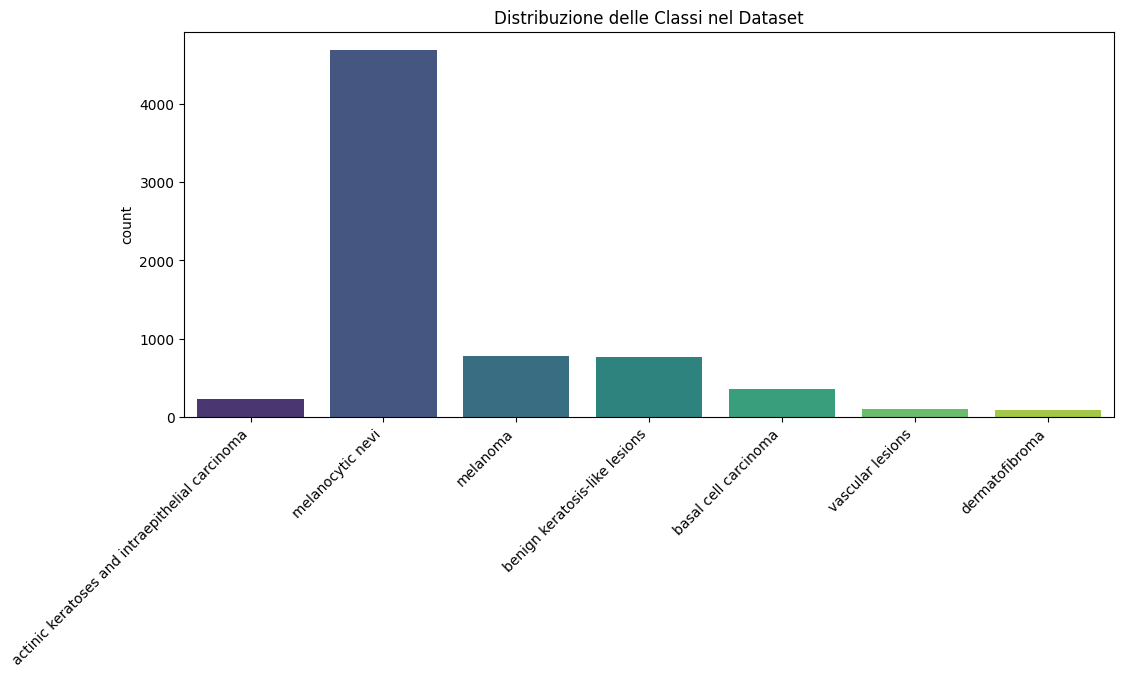

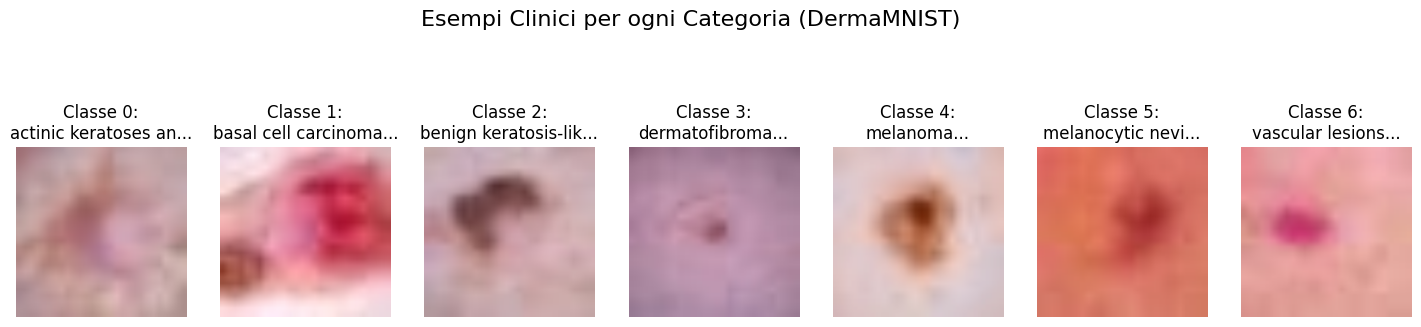

In [14]:

DATA_FLAG = 'dermamnist'
info = INFO[DATA_FLAG]
DataClass = getattr(medmnist, info['python_class'])
labels_map = info['label']
num_classes = len(labels_map)

# Trasformazioni (ResNet richiede 3 canali e normalizzazione ImageNet)
# Usiamo Resize(224) anche se l'input è 28x28 per compatibilità con i pesi ResNet
model_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Caricamento Dataset Originale (28x28)
train_dataset = DataClass(split='train', transform=model_transform, download=True)
val_dataset = DataClass(split='val', transform=model_transform, download=True)
test_dataset = DataClass(split='test', transform=model_transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# -----------------------------------------------------------------
# 2. EDA: DISTRIBUZIONE E 1 ESEMPIO PER CLASSE
# -----------------------------------------------------------------
print("\n" + "="*30)
print("FASE 2: ANALISI ESPLORATIVA (EDA)")
print("="*30)

# A. Distribuzione Classi (Fixed Warnings)
labels_train_raw = train_dataset.labels.flatten()
labels_train_names = [labels_map[str(i)] for i in labels_train_raw]

plt.figure(figsize=(12, 5))
sns.countplot(x=labels_train_names, hue=labels_train_names, palette='viridis', legend=False)
plt.title("Distribuzione delle Classi nel Dataset")
plt.xticks(rotation=45, ha='right')
plt.show()

# B. 1 Esempio per Classe

plt.figure(figsize=(18, 4))
found_classes = set()
count = 0

# Iteriamo sul dataset finché non troviamo un esempio per ogni classe
for img, target in train_dataset:
    label_idx = target.item()
    if label_idx not in found_classes:
        found_classes.add(label_idx)

        # Denormalizzazione per visualizzazione
        img_display = img.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)

        plt.subplot(1, num_classes, label_idx + 1)
        plt.imshow(img_display)
        plt.title(f"Classe {label_idx}:\n{labels_map[str(label_idx)][:20]}...")
        plt.axis('off')
        count += 1
    if count == num_classes:
        break
plt.suptitle("Esempi Clinici per ogni Categoria (DermaMNIST)", fontsize=16, y=1.05)
plt.show()


## Model development

Il sistema sfrutta il Transfer Learning utilizzando una rete neurale ResNet18 pre-addestrata su ImageNet. La strategia di training è di tipo "progressivo":

- Fase 1 (Feature Extraction): Il "corpo" della rete (backbone) viene congelato e si addestra solo lo strato finale (head). Questo permette di adattare il modello alle nuove classi senza corrompere le conoscenze geometriche già acquisite.

- Fase 2 (Fine-Tuning Totale): Una volta raggiunto un plateau di performance (gestito tramite Early Stopping), la rete viene interamente sbloccata. Viene applicato un learning rate molto basso per rifinire i filtri convoluzionali e catturare i dettagli microscopici specifici delle texture tumorali.

In [15]:

# -----------------------------------------------------------------
# 3. MODELLO E CONFIGURAZIONE (PHASE 1: FROZEN)
# -----------------------------------------------------------------

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze Backbone
for param in model.parameters():
    param.requires_grad = False

# Modifica Head
model.fc = nn.Linear(model.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# -----------------------------------------------------------------
# 4. TRAINING LOOP CON PROGRESSIVE UNFREEZING
# -----------------------------------------------------------------
epochs = 50
patience = 5
best_val_loss = float('inf')
counter = 0
is_unfrozen = False
history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

print(f"\nInizio Fase 1: Training della sola Head (Backbone Frozen) su {device}...")

for epoch in range(epochs):
    # Training
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device).squeeze().long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds, all_targets = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device).squeeze().long()
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    avg_train = running_loss / len(train_loader)
    avg_val = val_loss / len(val_loader)
    acc = accuracy_score(all_targets, all_preds)

    history['train_loss'].append(avg_train)
    history['val_loss'].append(avg_val)
    history['val_acc'].append(acc)

    status = "UNFROZEN" if is_unfrozen else "FROZEN"
    print(f"Epoch [{epoch+1:02d}/{epochs}] ({status}) | Loss T: {avg_train:.4f} | Loss V: {avg_val:.4f} | Acc V: {acc:.4f}")

    # Early Stopping & Unfreezing Logic
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            if not is_unfrozen:
                print(f"\n[!!!] PATIENCE RAGGIUNTA: Sblocco Backbone e abbasso Learning Rate (Phase 2)")
                for param in model.parameters():
                    param.requires_grad = True

                # Sostituiamo l'ottimizzatore con uno che vede tutto il modello e LR più basso
                optimizer = optim.Adam(model.parameters(), lr=1e-5)
                is_unfrozen = True
                counter = 0 # Reset patience
                model.load_state_dict(torch.load('best_model.pth'))
            else:
                print(f"\n--- STOP: Il modello non migliora ulteriormente. ---")
                break




Inizio Fase 1: Training della sola Head (Backbone Frozen) su cuda...
Epoch [01/50] (FROZEN) | Loss T: 0.9592 | Loss V: 0.7832 | Acc V: 0.7308
Epoch [02/50] (FROZEN) | Loss T: 0.7993 | Loss V: 0.7604 | Acc V: 0.7159
Epoch [03/50] (FROZEN) | Loss T: 0.7502 | Loss V: 0.7146 | Acc V: 0.7428
Epoch [04/50] (FROZEN) | Loss T: 0.7297 | Loss V: 0.6879 | Acc V: 0.7428
Epoch [05/50] (FROZEN) | Loss T: 0.7077 | Loss V: 0.6924 | Acc V: 0.7478
Epoch [06/50] (FROZEN) | Loss T: 0.6952 | Loss V: 0.6905 | Acc V: 0.7368
Epoch [07/50] (FROZEN) | Loss T: 0.6782 | Loss V: 0.6985 | Acc V: 0.7368
Epoch [08/50] (FROZEN) | Loss T: 0.6709 | Loss V: 0.6872 | Acc V: 0.7527
Epoch [09/50] (FROZEN) | Loss T: 0.6738 | Loss V: 0.6752 | Acc V: 0.7408
Epoch [10/50] (FROZEN) | Loss T: 0.6649 | Loss V: 0.6794 | Acc V: 0.7458
Epoch [11/50] (FROZEN) | Loss T: 0.6489 | Loss V: 0.6830 | Acc V: 0.7418
Epoch [12/50] (FROZEN) | Loss T: 0.6578 | Loss V: 0.6752 | Acc V: 0.7498
Epoch [13/50] (FROZEN) | Loss T: 0.6427 | Loss V: 0.67

## Model evaluation

Oltre all'accuratezza globale, il progetto pone l'accento sulla Matrice di Confusione e sul Report di Classificazione (Precision, Recall, F1-Score). In ambito medico, questo è cruciale per monitorare i Falsi Negativi: confondere un melanoma per un nevo benigno è l'errore che il modello cerca di minimizzare attraverso l'ottimizzazione dei pesi.

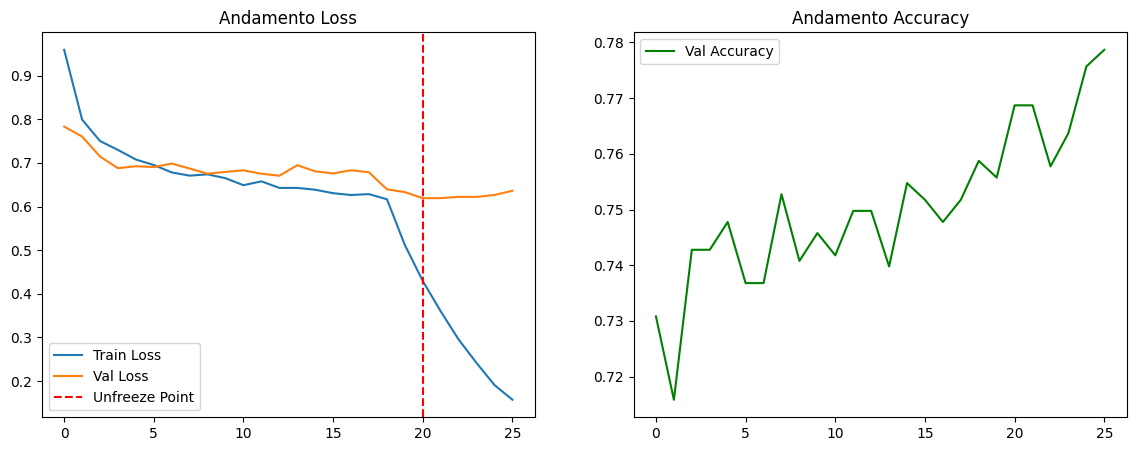

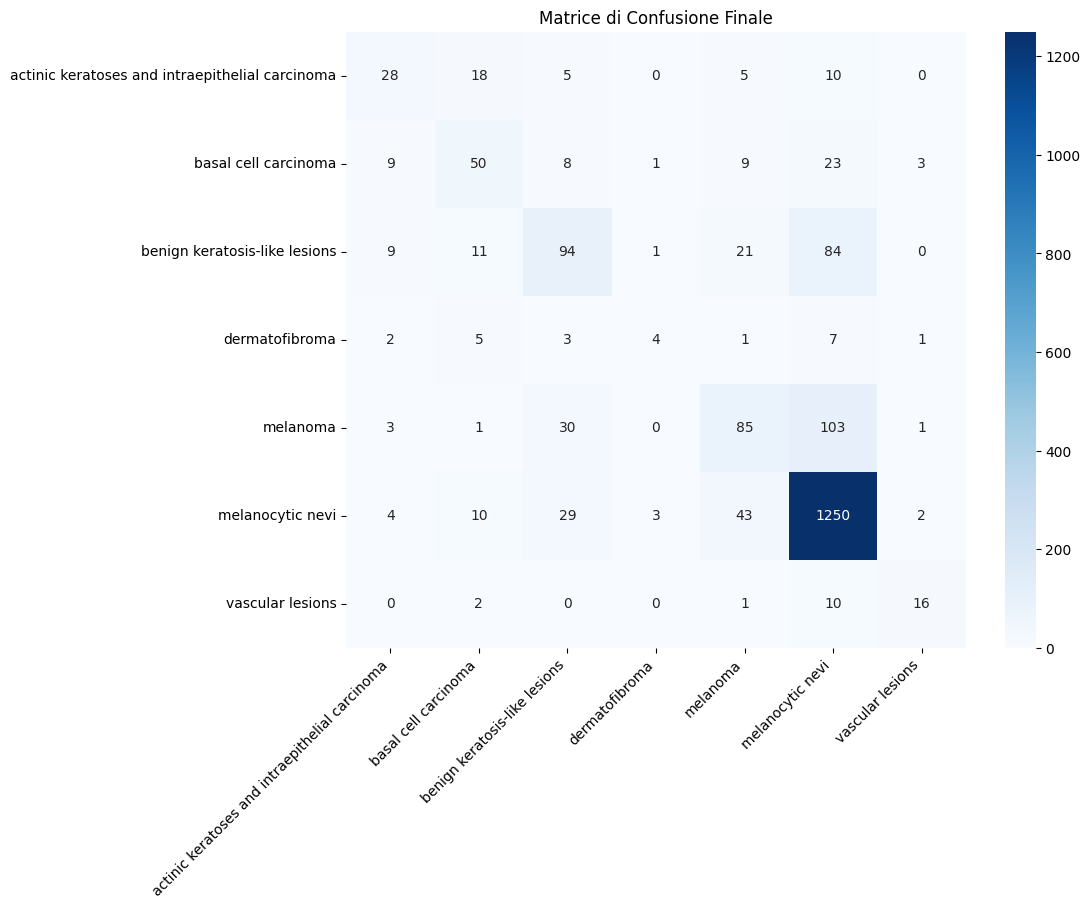


Report Tecnico Finale:
                                                 precision    recall  f1-score   support

actinic keratoses and intraepithelial carcinoma       0.51      0.42      0.46        66
                           basal cell carcinoma       0.52      0.49      0.50       103
                  benign keratosis-like lesions       0.56      0.43      0.48       220
                                 dermatofibroma       0.44      0.17      0.25        23
                                       melanoma       0.52      0.38      0.44       223
                               melanocytic nevi       0.84      0.93      0.88      1341
                               vascular lesions       0.70      0.55      0.62        29

                                       accuracy                           0.76      2005
                                      macro avg       0.58      0.48      0.52      2005
                                   weighted avg       0.74      0.76      0.75      

In [16]:
# -----------------------------------------------------------------
# 5. VISUALIZZAZIONE RISULTATI E TEST FINALE
# -----------------------------------------------------------------

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.axvline(x=len(history['train_loss']) - counter - 1 if is_unfrozen else 0,
            color='r', linestyle='--', label='Unfreeze Point')
plt.title('Andamento Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_acc'], label='Val Accuracy', color='green')
plt.title('Andamento Accuracy')
plt.legend()
plt.show()

# Caricamento miglior modello e Test
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(labels_map.values()), yticklabels=list(labels_map.values()))
plt.xticks(rotation=45, ha='right')
plt.title("Matrice di Confusione Finale")
plt.show()

print("\nReport Tecnico Finale:")
print(classification_report(y_true, y_pred, target_names=list(labels_map.values())))